## Hamiltoniano de amarre fuerte continuo para bajas energías

Para la construcción del Hamiltoniano de la bicapa rotada, nos trasladamos nuevamente al espacio recíproco. Es necesario considerar la aportación energética de cada capa rotada $\theta/2$ y de la interacción entre una capa y otra y recordar que se toman las mismas consideraciones de amarre fuerte que en la monocapa.

## Relación de dispersión 

In [1]:
from pylab import *

In [2]:
### Parametros
π = pi
d   = 1.42      # Å
dAB = 3.35      # Å
t   = 2.97      # eV
tAB = 0.33      # eV
tk  = 0.58      # eV Å^2
a   = sqrt(3)*d

θgrad   = 5
θ       = θgrad*(pi/180)

K      = 4*π/(3*a)*array([1,0])
absK   = abs(4*π/(3*a))
ΔK     = abs(2*absK*sin(θ/2))
#print (K,ΔK)

Auc = a*a*sqrt(3)/2
b1  = 4*pi/3/d*array([ sqrt(3)/2,0.5])
b2  = 4*pi/3/d*array([-sqrt(3)/2,0.5])

Auc_m = (3*sqrt(3)*d**2)/(8*(sin(θ/2))**2)
b1_m  = sqrt(3)*ΔK*array([0.5,-sqrt(3)/2])
b2_m  = sqrt(3)*ΔK*array([0.5, sqrt(3)/2])


g12  = b2
g13  = -1 * b1
τ0   = array([0,0])

# Vectores de separación entre los conos de la capa 1 y 2 
qb  = ΔK*array([     0, -1])
qtr = ΔK*array([ sqrt(3),1])/2
qtl = ΔK*array([-sqrt(3),1])/2


δ1 = d*array([       0,1])
δ2 = d*array([-sqrt(3),1])/2
δ3 = d*array([ sqrt(3),1])/2

ħvF = 1.5*d*2.970     # eV*angstrom, Fermi velocity for SLG


Retomando la simetría de la 1ZB para la supercelda, observamos que hay una interacción intercapa de los puntos de Dirac. La aportación de esta interacción se expresa mediante las matrices $\textbf{B}$, $\textbf{R}$ y $\textbf{L}$.

In [3]:
ϕ  = 2*π/3

#Matrices


B = tk/Auc*array([[1,1],
                  [1,1]])
R = tk/Auc*exp(-1J*dot(g12,τ0)) * array([[exp( 1J*ϕ),        1],
                                         [exp(-1J*ϕ),exp(1J*ϕ)]])
L = tk/Auc*exp(-1J*dot(g13,τ0))* array([[exp(-1J*ϕ),         1],
                                        [exp( 1J*ϕ),exp(-1J*ϕ)]])

Z  = zeros((2, 2))

Con los puntos de Dirac de ambas capas, se genera una red en el espacio recíproco y a través de un diccionario se contruye el Hamiltoniano intercapa, asignando a cada interacción una de las matrices anteriores.

In [4]:
# Construcción de la red y de su diccionario

O1 = array([0,0]) # origen
O2 = qb # origen
L1 = array([0,0])
L2 = array([0,0])+O2

###################################################
num  = 2 # Define el tamaño de la red
###################################################


n,m  = arange(-num,num+1,1),arange(-num,num+1,1)

N,M   = meshgrid(n,m)
N     = N.reshape( (2*num+1)*(2*num+1), )
M     = M.reshape( (2*num+1)*(2*num+1), )
coef  = column_stack([N,M])
bvec  = array([b1_m,b2_m])
Des   = dot( coef,bvec )
allL1 = L1+Des
allL2 = L2+Des

c = []
for n in range(len(allL1)):
    c.append(allL1[n])
    c.append(allL2[n])
    
DicRedRec = {}

for n,b in enumerate(c):
    key = n
    DicRedRec[key] = { "pos" : c[n],
                       "capa": n%2+1,
                       "α"   : coef[int(n/2)][0],
                       "β"   : coef[int(n/2)][1]
    }
    
# Hamiltoniano entre capas


Hcapas = zeros( (len(DicRedRec.keys()),len(DicRedRec.keys())),dtype=int )


# 0 -> Z (2x2)
# 1 -> qb
# 2 -> qtr
# 3 -> qtl
DicMat = { 0:Z, 1:B, 2:R, 3:L }

for n in range(0,len(DicRedRec.keys()),2):
    for key in DicRedRec:
        if DicRedRec[key]["capa"]==2:
            if (DicRedRec[key]["α"] ==DicRedRec[n]["α"] and DicRedRec[key]["β"] ==DicRedRec[n]["β"] ):
                Hcapas[(n,key)] = 1 # print ("qb",key)
                
            if (DicRedRec[key]["α"] ==DicRedRec[n]["α"] and DicRedRec[key]["β"] ==DicRedRec[n]["β"]+1 ):
                Hcapas[(n,key)] = 2 # print ("qtr",key)
                
            if (DicRedRec[key]["α"] ==DicRedRec[n]["α"]-1 and DicRedRec[key]["β"] ==DicRedRec[n]["β"] ):
                Hcapas[(n,key)] = 3 # print ("qtl",key)
                
Hm = [ [DicMat[i] for i in rw] for rw in Hcapas ]
H1 = asarray(bmat(Hm))
H2 = H1.conj().T

Hentrecapas = H1 + H2

Recordamos que se debe establecer el camino en el espacio recíproco:

In [5]:
# Definir los puntos k
Km  = array([0,0])
Kpm = -qb 
Γm  = qtr 
Mm  = -qtl/2
Km2 = Km

In [6]:
def GetkPath(kpoints,numNk):
    numP = len(kpoints)
    Dist = []
    for k in range(numP-1):
        veck = kpoints[k+1]-kpoints[k]
        D    = sqrt( dot(veck,veck) )
        Dist.append( D )
    Dist = array(Dist)
    Nk_p = array( [ int(numNk*D/Dist.sum()) for D in Dist ] )
    if (Nk_p.sum()<numNk):
        Nk_p[-1] = numNk - Nk_p[:-1].sum()
    KX, KY = array([]),array([])
    for k in range(numP-1):
        KX = concatenate([KX,linspace(kpoints[k][0],kpoints[k+1][0],Nk_p[k])]) 
        KY = concatenate([KY,linspace(kpoints[k][1],kpoints[k+1][1],Nk_p[k])])
    return column_stack((KX,KY)),concatenate([[0],cumsum(Nk_p)])

In [7]:
k,kticks    = GetkPath([Km,Kpm,Γm,Mm,Km2],1000)
kticklabels = [r"$K_m$",r"$K'_m$",r"$\Gamma$",r"$M_m$",r"$K_m$"]

Finalmente, para obtener el Hamiltoniano completo, a la aportación intercapas se le agrega la contribución energética intracapa:

In [8]:
# Construcción del Hamiltoniano 
def GetHam(k):
    Hdiag = zeros_like(Hentrecapas)
    for key in DicRedRec:
        diagonal = zeros(len(DicRedRec.keys()))
        diagonal[key] = 1
        
        if (DicRedRec[key]["capa"]==1):
            # Capa 1
            sh  = DicRedRec[key]["α"]*b1_m+DicRedRec[key]["β"]*b2_m
            #fk  = exp(1J*dot( dot(Rpθ2,k+sh), dot(Rpθ2,δ1) )) \
            #     +exp(1J*dot( dot(Rpθ2,k+sh), dot(Rpθ2,δ2) )) \
            #     +exp(1J*dot( dot(Rpθ2,k+sh), dot(Rpθ2,δ3) ))
            q  = k + sh
            # print (q,DicRedRec[key]["α"],DicRedRec[key]["β"],k )
            fk = q[0]*( cos(θ/2)+1J*sin(θ/2) )+q[1]*( sin(θ/2)-1J*cos(θ/2) )
            # print (ħvF*fk,DicRedRec[key]["α"],DicRedRec[key]["β"])
        if (DicRedRec[key]["capa"]==2):
            # Capa 2
            
            sh  = DicRedRec[key]["α"]*b1_m+DicRedRec[key]["β"]*b2_m
            #fk  = exp(1J*dot( dot(Rmθ2,k+sh), dot(Rmθ2,δ1) )) \
            #     +exp(1J*dot( dot(Rmθ2,k+sh), dot(Rmθ2,δ2) )) \
            #     +exp(1J*dot( dot(Rmθ2,k+sh), dot(Rmθ2,δ3) ))
            q  = k + sh + qb
            # print (q,DicRedRec[key]["α"],DicRedRec[key]["β"],k )
            fk = q[0]*( cos(-θ/2)+1J*sin(-θ/2) )+q[1]*( sin(-θ/2)-1J*cos(-θ/2) )
            # print (ħvF*fk,DicRedRec[key]["α"],DicRedRec[key]["β"])
        # Hk   = array([[ 0 , -t*fk],[-t*conj(fk), 0]])
        Hk   = array([[ 0 , ħvF*fk],[ħvF*conj(fk), 0]])
        
        
        Htmp = array(kron(diag(diagonal), [Hk]))[0]
        Hdiag += Htmp
        
    H = Hentrecapas + Hdiag
      
    eigenvalue,featurevector=linalg.eig(H)
    return sort(eigenvalue.real)

In [9]:
from multiprocessing import Pool

Se procede a calcular los eigenvalores y se grafican, generando la estructura de bandas:

In [10]:
p  = Pool()
Ek = p.map(GetHam,k)
Ek = array(Ek)

In [11]:
mpl.rcParams.update({'font.size': 18, 'text.usetex': True})
mpl.rcParams.update({'axes.linewidth':1.5})
mpl.rcParams.update({'axes.labelsize':'large'})
mpl.rcParams.update({'xtick.major.size':6})
mpl.rcParams.update({'xtick.minor.size':4})
mpl.rcParams.update({'ytick.major.size':6})
mpl.rcParams.update({'ytick.minor.size':4})
mpl.rcParams.update({'xtick.major.width':1.5})
mpl.rcParams.update({'xtick.minor.width':1.0})
mpl.rcParams.update({'ytick.major.width':1.5})
mpl.rcParams.update({'ytick.minor.width':1.0})
mpl.rcParams.update({'legend.frameon':False,'legend.framealpha':0.0})

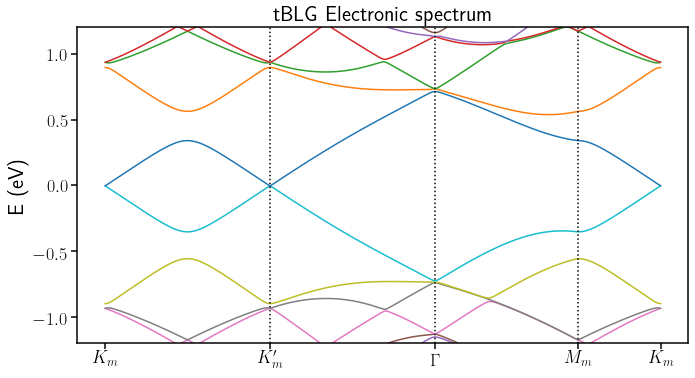

In [12]:
fig,axes = plt.subplots(ncols=1,nrows=1,figsize=(10,5.6))
numNk = len(Ek)
for n in range(len(Ek.T)):
    plot(range(numNk),Ek.T[n])
    
maxEk = Ek.max()
minEk = Ek.min()
for tick in kticks[1:-1]:
    axes.plot([tick,tick],[minEk,maxEk],":",c="k")
axes.set_xticks(kticks)
axes.set_xticklabels(kticklabels)
axes.set_ylim(-1.2,1.2)

axes.set_ylabel('E (eV)') 
axes.set_title('tBLG Electronic spectrum') 


fig.tight_layout()

En el caso de la bicapa rotada, se aparecce un mayor número de estados electrónicos cerca del nivel de Fermi. Estas bandas planas se asocian a una disminución de la velocidad de los electrones, comparada con la monocapa de grafeno.